In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.preprocessing import MinMaxScaler

1.8.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://github.com/zacheberhart/Convolutional-Disentangled-Variational-Autoencoder/blob/master/Convolutional%20Disentangled%20Variational%20Autoencoder%20(%CE%B2-VAE).ipynb

In [4]:
CUDA = True

ZDIMS = 30
# BETA = 5
LR = 1e-3
EPOCHS = 25
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 10

In [5]:
# EPOCH = 10
# BATCH_SIZE = 32
# LR = 0.005
# path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks/train_test_imbal/'
path = '/content/drive/MyDrive/ecg/'

In [6]:
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [7]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [8]:
scaler = MinMaxScaler()
X_train_old = scaler.fit_transform(X_train_old)


In [9]:
scaler1 = MinMaxScaler()
X_test_old = scaler1.fit_transform(X_test_old)

In [10]:
# X_train_old = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train_old = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test_old = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test_old = np.loadtxt(path + 'y_test.csv', delimiter=',')

In [11]:
# print(X_train_old.shape)
# print(y_train_old.shape)
# print(X_test_old.shape)
# print(y_test_old.shape)

In [12]:
num = 7.0

In [13]:
y_train = y_train_old[np.where(y_train_old == num)[0]]
X_train = X_train_old[np.where(y_train_old == num)[0]]
X_test = X_test_old[np.where(y_test_old == num)[0]]
y_test = y_test_old[np.where(y_test_old == num)[0]]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3617, 256)
(3617,)
(228, 256)
(228,)


In [15]:
X_train = np.expand_dims(X_train,axis=2)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(3617, 256, 1)
(228, 256, 1)


In [16]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [17]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [18]:
print(len(train_loader.dataset))

3617


In [19]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [20]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, c=50, c_delta=0.001, beta=0.1, beta_delta=0):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.c = c
        self.c_delta = c_delta
        self.beta = beta
        self.beta_delta = beta_delta
        self.encoder = nn.Sequential(
            
            # input is 64 x 1 x 256
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.LeakyReLU(),

            # conv layer 2
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            # nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # # conv layer 3
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            # nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 4 
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            #nn.BatchNorm2d(1024), # OPTIONAL
            nn.LeakyReLU(0.2)

        )

        self.decoder = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            # nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # # deconv layer 2
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            # nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 3
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            # nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 4
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            nn.Sigmoid()

        )
        
        # conv fc
        # self.features_to_hidden = nn.Sequential(
        #     nn.Linear(1024, 60),
        #     nn.LeakyReLU(0.2)
        # )
        self.fc11 = nn.Linear(16, self.zdims) # mu
        self.fc12 = nn.Linear(16, self.zdims) # logvar
        self.fc13 = nn.Linear(16, self.zdims) # log spike
        # self.latent_to_features = nn.Sequential(
        #     nn.Linear(self.zdims, 60), nn.LeakyReLU(0.2),
        #     nn.Linear(60, 1024), nn.LeakyReLU(0.2)
        # )
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 16)
        # self.fc22 = nn.Linear(250, 256)


    def encode(self, x):
        conv = self.encoder(x)
        # print(conv.shape)
        # conv_flatten = torch.flatten(conv)
        # hidden = self.features_to_hidden(conv_flatten)
        conv = conv.view(BATCH_SIZE,-1)
        # print("conv after view", conv.shape)
        mu = self.fc11(conv)
        # print("mu", mu.shape)
        logvar = self.fc12(conv)
        # print("logvar", logvar.shape)
        logspike = -F.relu(-self.fc13(conv))
        return mu, logvar, logspike
    
    def decode(self, z):
        deconv_input = F.relu(self.fc2(z))
        
        # deconv_input = self.latent_to_features(z)
        # print("deconv", deconv_input.shape)
        # deconv_input = deconv_input.view(64,16)
        # print("deconv", deconv_input.shape)
        # deconv_input = deconv_input.view(BATCH_SIZE,32,256)
        deconv_input = torch.unsqueeze(deconv_input,1)# world models: [-1, 1, 1, 1024] # and this # 30,1024,430
        # print("after view", deconv_input.shape)
        recon_x = self.decoder(deconv_input)
        # recon_x = self.fc22(recon_x)
        return recon_x

    # changed
    def reparameterize(self, mu, logvar, logspike):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        eta = torch.rand_like(std)
        selection = torch.sigmoid(self.c*(eta + logspike.exp() - 1))
        return selection.mul(z)
    
    def forward(self, x):

        mu, logvar, logspike = self.encode(x)
        # print("mu", mu.shape)
        z = self.reparameterize(mu, logvar, logspike)
        # print(z.shape, "z, forward")
        recon_x = self.decode(z)
        # recon_x = recon_x.permute(0,2,1)
        return recon_x, mu, logvar, logspike, z

    def update_c(self):
      self.c += self.c_delta
    
    def update_beta(self):
      self.beta += self.beta_delta


In [21]:
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [22]:
# def conv_output_shape(l=256, kernel_sz=3, stride=2, dilation=1,pad=1):
#         h = (l + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         h = (h + (2 * pad) - (dilation * (kernel_sz - 1)) - 1)// stride + 1
#         return h
# print(conv_output_shape())

In [23]:
# def conv_transp_output_shape(l=16, kernel_size=4, stride=2, dilation=1,pad=1):
#   h = (l - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   h = (h - 1) * stride - 2 * pad + dilation * (kernel_size-1)  + 1
#   return h
# print(conv_transp_output_shape())

In [24]:
# print(model)

In [25]:
def loss_function(recon_x, x, mu, logvar, logspike):
    '''Use a beta value of 1 for a vanilla VAE'''

    flat_shape = 64*256
    alpha = 0.5
    BCE = F.binary_cross_entropy(recon_x.view(-1, flat_shape), x.view(-1, flat_shape), reduction='mean')
    # MSE = F.mse_loss(recon_x.view(-1, flat_shape), x.view(-1, flat_shape),reduction= 'mean')
    # KL Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    spike = torch.clamp(logspike.exp(), 1e-6, 1.0 - 1e-6)

    prior1 = -0.5 * torch.sum(spike.mul(1 + logvar - mu.pow(2) - logvar.exp()))
    prior21 = (1 - spike).mul(torch.log((1 - spike) / (1 - alpha)))
    prior22 = spike.mul(torch.log(spike / alpha))
    prior2 = torch.sum(prior21 + prior22)
    PRIOR = prior1 + prior2
    LOSS = BCE + (model.beta * PRIOR)

    return LOSS, PRIOR, BCE

In [26]:
def train(epoch):

    model.train()
    train_loss = 0
    prior_loss = 0
    bce_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # data = data[0]
        data = data.to(device)

        optimizer.zero_grad()
        
        data = data.permute(0,2,1)
        recon_batch, mu, logvar, logspike, Z = model(data.type(torch.cuda.FloatTensor))

        
        loss, prior, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar, logspike)
        loss.backward()
        train_loss += loss.item()
        prior_loss += prior.item()
        bce_loss += bce.item()
        optimizer.step()
        
        model.update_c()
        model.update_beta()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    data_inv = scaler.inverse_transform(data.view(-1,256).detach().cpu().numpy())
    recon_batch_inv = scaler.inverse_transform(recon_batch.view(-1,256).detach().cpu().numpy())
    if(epoch==99):
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), prior_loss / len(train_loader.dataset), bce_loss / len(train_loader.dataset)

In [27]:
train_loss_list = []
prior_list = []
bce_list = []
for epoch in range(50):
    loss, prior, bce = train(epoch)
    train_loss_list.append(loss)
    prior_list.append(prior)
    bce_list.append(bce)

Train Epoch: 0 [0/3617 (0%)]	Loss: 1.476047
Train Epoch: 0 [640/3617 (18%)]	Loss: 1.268585
Train Epoch: 0 [1280/3617 (36%)]	Loss: 1.129466
Train Epoch: 0 [1920/3617 (54%)]	Loss: 1.035944
Train Epoch: 0 [2560/3617 (71%)]	Loss: 0.972713
Train Epoch: 0 [3200/3617 (89%)]	Loss: 0.926402
====> Epoch: 0 Average loss: 1.0913
Train Epoch: 1 [0/3617 (0%)]	Loss: 0.906595
Train Epoch: 1 [640/3617 (18%)]	Loss: 0.883450
Train Epoch: 1 [1280/3617 (36%)]	Loss: 0.843718
Train Epoch: 1 [1920/3617 (54%)]	Loss: 0.810192
Train Epoch: 1 [2560/3617 (71%)]	Loss: 0.793537
Train Epoch: 1 [3200/3617 (89%)]	Loss: 0.784725
====> Epoch: 1 Average loss: 0.8232
Train Epoch: 2 [0/3617 (0%)]	Loss: 0.781493
Train Epoch: 2 [640/3617 (18%)]	Loss: 0.778144
Train Epoch: 2 [1280/3617 (36%)]	Loss: 0.776252
Train Epoch: 2 [1920/3617 (54%)]	Loss: 0.775111
Train Epoch: 2 [2560/3617 (71%)]	Loss: 0.774397
Train Epoch: 2 [3200/3617 (89%)]	Loss: 0.773940
====> Epoch: 2 Average loss: 0.7690
Train Epoch: 3 [0/3617 (0%)]	Loss: 0.773744

In [28]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(0,2,1)
    decoded, mu, logvar, logspike, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar, logspike)
    img = scaler.inverse_transform(model.decode(z).view(-1,256).detach().cpu().numpy())
    z = z.cpu().detach().numpy()[0]
    # print(z.shape)
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image[0,0,:], ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

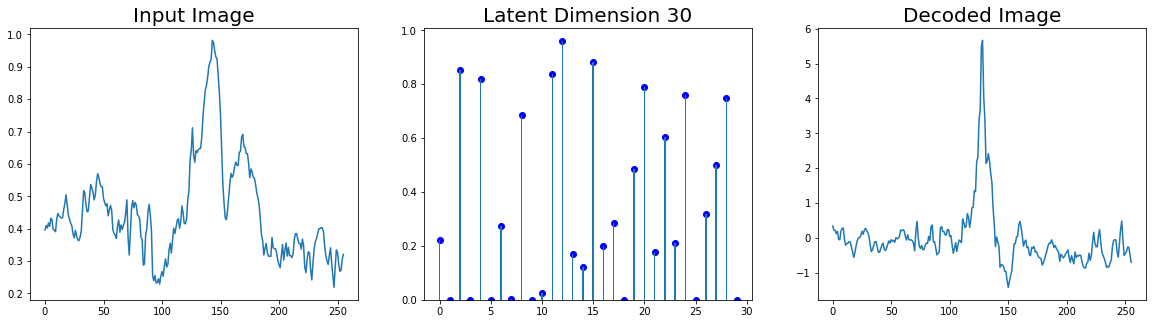

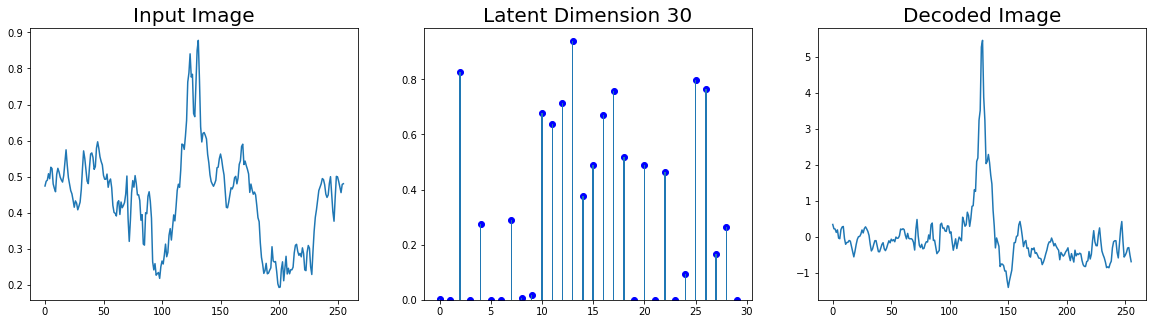

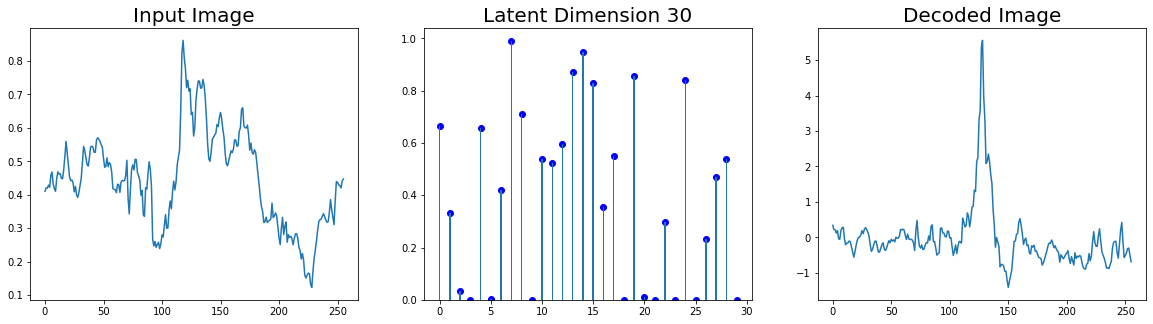

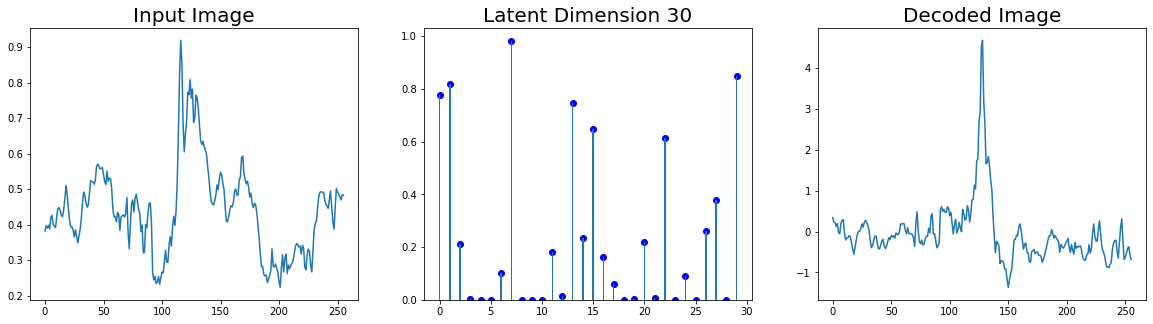

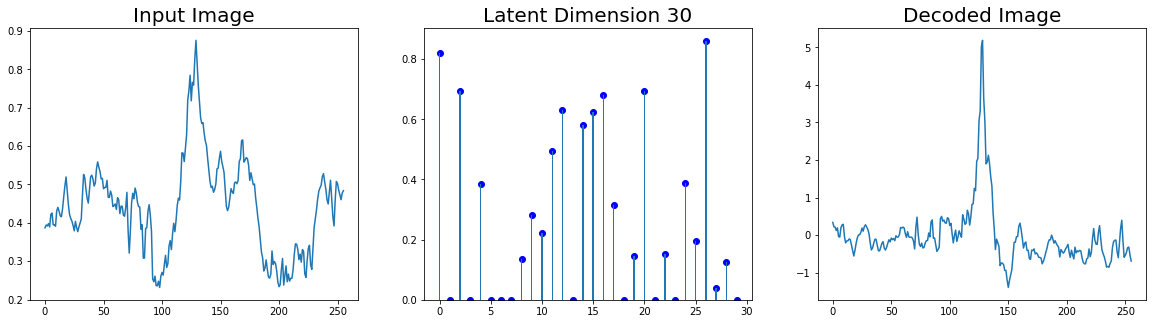

In [29]:
dataloader_iterator = iter(train_loader)
for i in range(5):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [30]:
# from sklearn.manifold import TSNE 
# latent_ecg = []
# target = []
# for data, targets in train_loader:
#     z_means, z_logvar, z_logspike = model.encode(data.permute(0,2,1).type(torch.cuda.FloatTensor))
#     # print(z_means.shape)
#     latent_ecg.extend(z_means.detach().cpu().numpy())
#     target.extend(targets.numpy())

# # take first 1k
# latent = np.array(latent_ecg)
# # print(latent.shape)
# target = np.array(target)
# tsne = TSNE(n_components=2, random_state=0, verbose=5, n_iter=500)

# X = tsne.fit_transform(latent_ecg)

In [31]:
# plt.figure(figsize=(8,8))
# scatter = plt.scatter(X[:,0], X[:,1], c=target)
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('TSNE')
# plt.show()

In [32]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    prior_loss = 0
    bce_loss = 0
    recon_list = []
    with torch.no_grad():
        
        for i, (data,_) in enumerate(test_loader):
            # data = data[0]
            data = data.to(device)
            data = data.permute(0,2,1)
            # data_reshape = data.view(len(data), 1, 256).type(torch.cuda.FloatTensor)
            recon_batch, mu, logvar, logspike, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            # print(recon_batch.shape)
            loss, prior, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar, logspike)
            test_loss += loss.item()
            prior_loss += prior.item()
            bce_loss += bce.item()
            # print(">>>>>>", data.view(-1,256).shape)
            # if i % LOG_INTERVAL == 0:
    data_inv = scaler1.inverse_transform(data.view(-1,256).cpu().data.numpy())
    recon_batch_inv = scaler1.inverse_transform(recon_batch.view(-1,256).cpu().data.numpy())
    # data = data.view(-1,256).cpu().data.numpy()
    # recon_batch = recon_batch.view(-1,256).cpu().data.numpy()
    # n = min(data.size(0), 8)
    # comparison = torch.cat([data[:n], recon_batch[:n]])
    # print(comparison)
    # save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    if(epoch==99):
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    prior_loss /= len(test_loader.dataset)
    bce_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, prior_loss, bce_loss, recon_list

In [33]:
test_loss_list = []
prior_list_tst = []
bce_list_tst = []
for epoch in range(50):
    loss, prior, bce, recon_list = test(epoch)
    test_loss_list.append(loss)
    prior_list_tst.append(prior)
    bce_list_tst.append(bce)

====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss: 0.6510
====> Test set loss:

In [34]:
copy_recon = recon_list
recon_all = torch.cat(copy_recon, dim=0)
print(recon_all.shape)

torch.Size([192, 1, 256])


In [35]:
recon_all_1 = torch.squeeze(recon_all, dim=1)
print(recon_all_1.shape)

torch.Size([192, 256])


In [36]:
# sample from latent space

def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      # print(sample.shape)
      sample = model.decode(sample).cpu()
      sample = scaler.inverse_transform(sample.view(-1,256).cpu().data.numpy())
      # sample = sample.permute(0,2,1)
      # print(sample.shape)
      samples.append(sample)
    return samples

In [37]:
samples = sample_latent(model,3000)
print(len(samples))

46


In [38]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

(64, 256)
(2944, 256)


In [39]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/sparse_conv_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/sparse_conv_vae/'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/sparse_conv_vae/')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [40]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

      # for i in range(5):
      #     a[1][i].clear()
      #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
  plt.show();

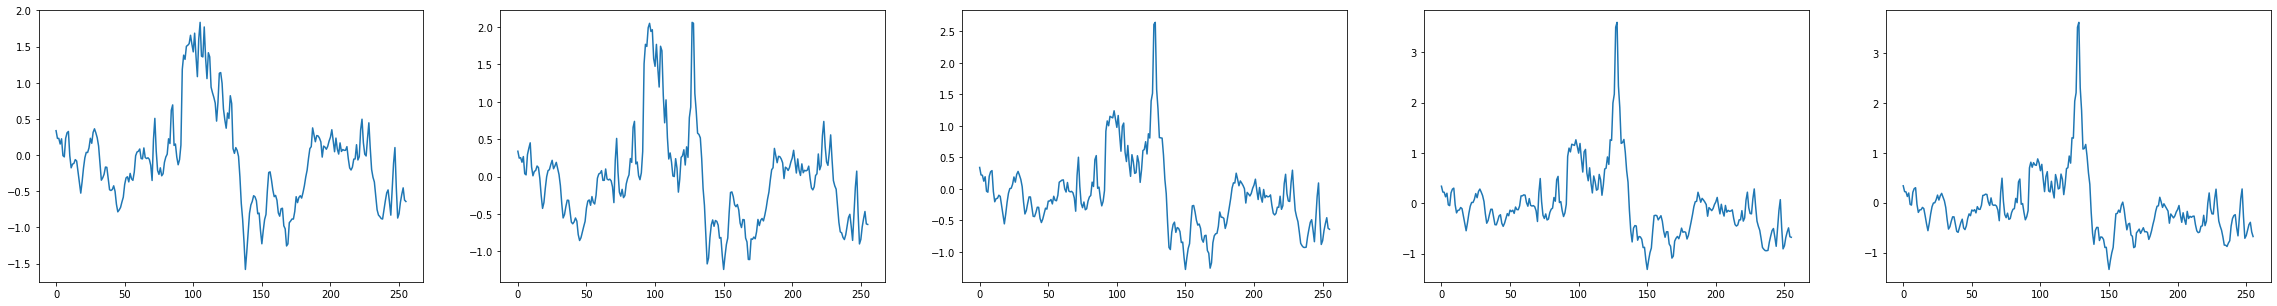

In [41]:
view_samples(all_samps)

In [42]:
# f, a = plt.subplots(1, 5, figsize=(40,5))
# view_data = sample[30:35]

# for i in range(5):
#     a[i].plot(view_data[i])

#     # for i in range(5):
#     #     a[1][i].clear()
#     #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
# plt.show();

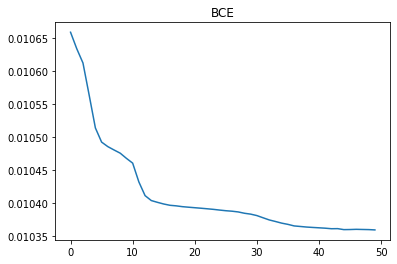

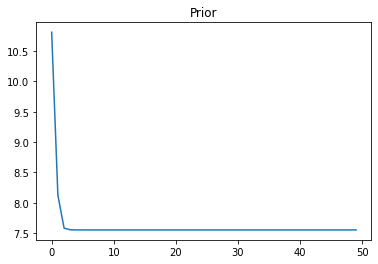

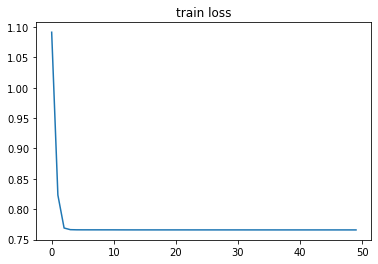

In [43]:
plt.plot(range(len(bce_list)), bce_list)
plt.title("BCE")
plt.show()
plt.plot(range(len(prior_list)), prior_list)
plt.title("Prior")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title("train loss")
plt.show()

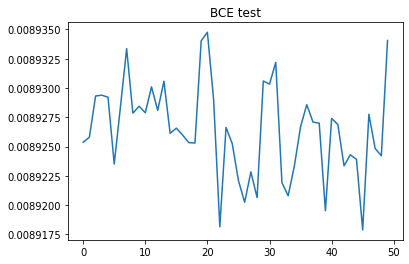

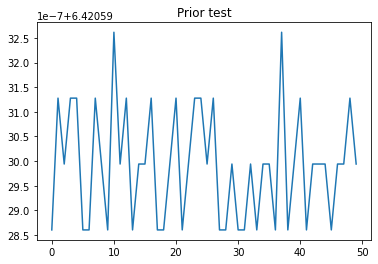

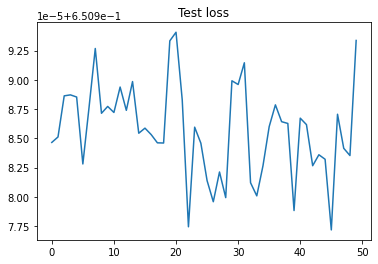

In [44]:
plt.plot(range(len(bce_list_tst)), bce_list_tst)
plt.title("BCE test")
plt.show()
plt.plot(range(len(prior_list_tst)), prior_list_tst)
plt.title("Prior test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("Test loss")
plt.show()

In [45]:
data = recon_all_1.cpu().data.numpy()
classes = y_test[:-7]
print(classes.shape)

(221,)


In [46]:
# from sklearn.decomposition import PCA
# x_pca = PCA(n_components=50,random_state=42).fit_transform(data)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA')

In [47]:
# from sklearn.manifold import TSNE
# x_tsne = TSNE(n_components=2,random_state=42,perplexity=100, verbose=5, n_iter=500).fit_transform(x_pca)
# plt.figure(figsize=(8,8))

# categories=['N','L','R','V','A','F','f','/']
# scatter = plt.scatter(x_tsne[:,0],x_tsne[:,1],c=classes, cmap='inferno_r')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and TSNE')

In [48]:
# import umap
# reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=100, a = 0.5, b = 1.2)
# embedding = reducer.fit_transform(x_pca)
# embedding.shape
# plt.figure(figsize=(8,8))

# plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=classes, cmap='inferno')
# plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
# plt.title('PCA and UMAP')